# Abalone Age Prediction with KNN and an Improved Polynomial KNN (with log1p)

This notebook trains a **KNN regression** model on the UCI Abalone dataset (via `ucimlrepo`).

It includes:
- Loading the dataset (`fetch_ucirepo(id=1)`)
- Preprocessing: **One-Hot Encoding** (`Sex`) + **Standard Scaling**
- A function to find the best **k** via cross-validation (minimizing MAE)
- Final evaluation: **R²**, **RMSE**, **MAE**, and tolerance “accuracy” (±1, ±2 rings)
- An improved model: **log1p (numeric only) → Polynomial Features → KNN**
- Clean result tables + comparison charts + scatter plots with an **ideal
- Final evaluation: **R²**, **RMSE**, **MAE**, and tolerance “accuracy” (±1, ±2 rings)
- binary classification for young and old

In [ ]:
# If running on Colab / fresh environment:
!pip -q install ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from IPython.display import display

In [ ]:
# Fetch dataset (UCI id=1 is Abalone)
abalone = fetch_ucirepo(id=1)

X = abalone.data.features.copy()
y = abalone.data.targets.copy()

# y is typically a DataFrame with column 'Rings'
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

print("X shape:", X.shape)
print("y shape:", y.shape)
display(X.head())
display(y.head())

X shape: (4177, 8)
y shape: (4177,)


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


,Rings
0,15
1,7
2,9
3,10
4,7


In [ ]:
# Quick sanity checks
print("Missing values in X:", X.isna().sum().sum())
print("Missing values in y:", y.isna().sum())
print("\nColumn dtypes:")
display(X.dtypes)

Missing values in X: 0
Missing values in y: 0

Column dtypes:


,0
Sex,object
Length,float64
Diameter,float64
Height,float64
Whole_weight,float64
Shucked_weight,float64
Viscera_weight,float64
Shell_weight,float64


## Train/Test Split (with stratification via bins)

For regression, we approximate stratification by binning the target (`Rings`) so the train/test sets have similar ring distributions.


In [ ]:
RANDOM_STATE = 42

# Create bins for stratification
try:
    y_bins = pd.qcut(y, q=10, duplicates="drop")
except ValueError:
    y_bins = pd.cut(y, bins=10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_bins
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (3341, 8) Test size: (836, 8)


## Preprocessing (Base KNN)

- `Sex` is categorical (`M`, `F`, `I`) → **OneHotEncoder**
- Numeric columns → passthrough
- Then apply **StandardScaler** before KNN (distance-based)


In [ ]:
# Helper to create OneHotEncoder compatibly across sklearn versions
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # older sklearn
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# Identify categorical and numeric columns automatically
cat_cols = list(X_train.select_dtypes(include=["object", "category"]).columns)
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

preprocessor_base = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", make_ohe(), cat_cols),
    ],
    remainder="drop"
)

Categorical columns: ['Sex']
Numeric columns: ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']


## Metrics + Report Helper

We report:
- **MAE**
- **RMSE** (computed as `sqrt(MSE)` for compatibility across sklearn versions)
- **R²**
- **Tolerance Accuracy (±1, ±2)**: percentage of predictions within ±1 or ±2 rings

> KNN outputs continuous values; tolerance accuracy is a practical “how often we're close enough” measure.


In [ ]:
def tolerance_accuracy(y_true, y_pred, tol=1.0):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_pred - y_true) <= tol)

def knn_report(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # compatible across sklearn versions
    r2 = r2_score(y_true, y_pred)

    tol1 = tolerance_accuracy(y_true, y_pred, tol=1.0)
    tol2 = tolerance_accuracy(y_true, y_pred, tol=2.0)

    return pd.DataFrame([{
        "Model": label,
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "R2": round(r2, 4),
        "Tolerance Acc (±1)": round(tol1, 4),
        "Tolerance Acc (±2)": round(tol2, 4),
    }])

def display_report_table(report_df, title="Results"):
    styled = (
        report_df.style
        .format({
            "MAE": "{:.4f}",
            "RMSE": "{:.4f}",
            "R2": "{:.4f}",
            "Tolerance Acc (±1)": "{:.2%}",
            "Tolerance Acc (±2)": "{:.2%}",
        })
        .set_caption(title)
        .hide(axis="index")
        .set_table_styles([
            {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold")]},
            {"selector": "th", "props": [("text-align", "left")]},
            {"selector": "td", "props": [("padding", "8px 12px")]},
        ])
        .background_gradient(subset=["R2", "Tolerance Acc (±1)", "Tolerance Acc (±2)"])      # higher is better
        .background_gradient(subset=["MAE", "RMSE"], cmap="Reds_r")                          # lower is better
    )
    display(styled)

def plot_true_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.title(title)
    plt.xlabel("True Rings")
    plt.ylabel("Predicted Rings")

    # Ideal diagonal (perfect prediction): y = x
    y_true_arr = np.asarray(y_true)
    min_v = float(min(y_true_arr.min(), np.min(y_pred)))
    max_v = float(max(y_true_arr.max(), np.max(y_pred)))
    plt.plot([min_v, max_v], [min_v, max_v], linestyle="--", linewidth=2)

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Base KNN: Find Best k (Cross-Validation)

We tune `k` using **5-fold CV** to minimize **MAE**.


In [ ]:
def tune_k_knn(X_train, y_train, preprocessor, k_values, cv_splits=5):
    results = []
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)

    for k in k_values:
        model = Pipeline([
            ("prep", preprocessor),
            ("scaler", StandardScaler()),
            ("knn", KNeighborsRegressor(n_neighbors=k, weights="distance", p=2))
        ])

        scores = cross_val_score(
            model, X_train, y_train,
            scoring="neg_mean_absolute_error",
            cv=cv,
            n_jobs=-1
        )

        mae_scores = -scores
        results.append({
            "k": k,
            "cv_mae_mean": mae_scores.mean(),
            "cv_mae_std": mae_scores.std()
        })

    return pd.DataFrame(results).sort_values("k")

k_values = list(range(1, 31, 2))  # odd ks from 1..29
cv_k_results = tune_k_knn(X_train, y_train, preprocessor_base, k_values)

best_k = int(cv_k_results.loc[cv_k_results["cv_mae_mean"].idxmin(), "k"])
print("Best k by CV MAE:", best_k)

display(cv_k_results.head())

Best k by CV MAE: 19


,k,cv_mae_mean,cv_mae_std
0,1,1.982924,0.073457
1,3,1.685846,0.038020
2,5,1.608703,0.029866
3,7,1.568559,0.028435
4,9,1.554532,0.026754


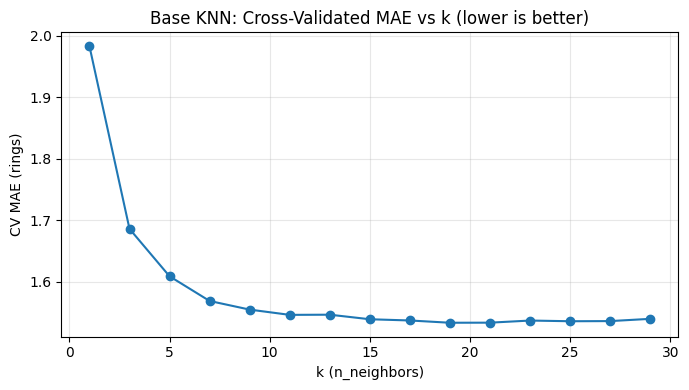

In [ ]:
# Plot CV MAE vs k
plt.figure(figsize=(7,4))
plt.plot(cv_k_results["k"], cv_k_results["cv_mae_mean"], marker="o")
plt.title("Base KNN: Cross-Validated MAE vs k (lower is better)")
plt.xlabel("k (n_neighbors)")
plt.ylabel("CV MAE (rings)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Model,MAE,RMSE,R2,Tolerance Acc (±1),Tolerance Acc (±2)
Base KNN (k=19),1.5798,2.2612,0.5220,45.93%,72.73%


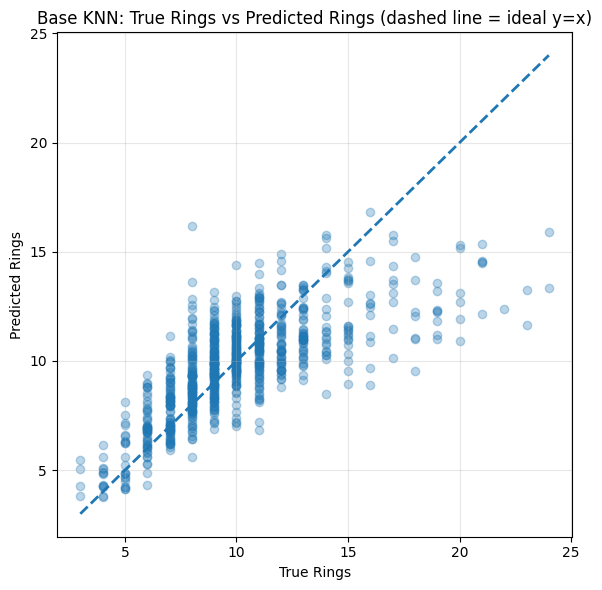

In [ ]:
# Train and evaluate the best base KNN
base_knn = Pipeline([
    ("prep", preprocessor_base),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=best_k, weights="distance", p=2))
])

base_knn.fit(X_train, y_train)
pred_base = base_knn.predict(X_test)

base_report = knn_report(y_test, pred_base, label=f"Base KNN (k={best_k})")
display_report_table(base_report, title="Base KNN Results")

plot_true_vs_pred(y_test, pred_base, title="Base KNN: True Rings vs Predicted Rings (dashed line = ideal y=x)")

## Improvement: log1p + Polynomial Features + KNN (log1p only in the improved model)

For the improved model, we apply:
1. **log1p** to numeric features (helps reduce skew, especially for weight features),
2. **PolynomialFeatures** on numeric features (adds interactions like `Length×Diameter`),
3. **One-Hot Encoding** for `Sex`,
4. **StandardScaler**,
5. KNN regression.

We tune:
- polynomial degree (1–3)
- k
- weights and distance metric


In [ ]:
# Preprocessor for the improved model: log1p -> polynomial (numeric only), plus one-hot for categorical
log1p_tf = FunctionTransformer(np.log1p)

preprocessor_improved = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("log1p", log1p_tf),
            ("poly", PolynomialFeatures(include_bias=False))
        ]), num_cols),
        ("cat", make_ohe(), cat_cols),
    ],
    remainder="drop"
)

improved_pipe = Pipeline([
    ("prep", preprocessor_improved),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

param_grid = {
    # polynomial degree is inside the numeric pipeline within the ColumnTransformer
    "prep__num__poly__degree": [1, 2, 3],
    "knn__n_neighbors": list(range(1, 31, 2)),
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(
    improved_pipe,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1
)

gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV MAE:", round(-gs.best_score_, 4))

Best params: {'knn__n_neighbors': 25, 'knn__p': 1, 'knn__weights': 'distance', 'prep__num__poly__degree': 3}
Best CV MAE: 1.5001


Model,MAE,RMSE,R2,Tolerance Acc (±1),Tolerance Acc (±2)
Improved KNN (log1p + poly + best),1.5380,2.2100,0.5434,46.41%,72.97%


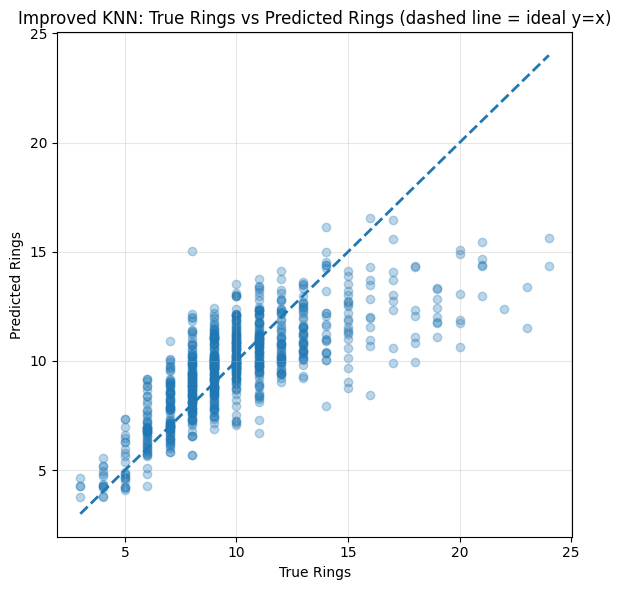

In [ ]:
# Evaluate improved model
pred_improved = gs.predict(X_test)

improved_report = knn_report(
    y_test, pred_improved,
    label="Improved KNN (log1p + poly + best)"
)
display_report_table(improved_report, title="Improved Model Results (log1p + polynomial + KNN)")

plot_true_vs_pred(y_test, pred_improved, title="Improved KNN: True Rings vs Predicted Rings (dashed line = ideal y=x)")

In [ ]:
# Comparison table
comparison = pd.concat([base_report, improved_report], ignore_index=True)
display_report_table(comparison, title="Model Comparison (Base vs Improved)")

Model,MAE,RMSE,R2,Tolerance Acc (±1),Tolerance Acc (±2)
Base KNN (k=19),1.5798,2.2612,0.5220,45.93%,72.73%
Improved KNN (log1p + poly + best),1.5380,2.2100,0.5434,46.41%,72.97%


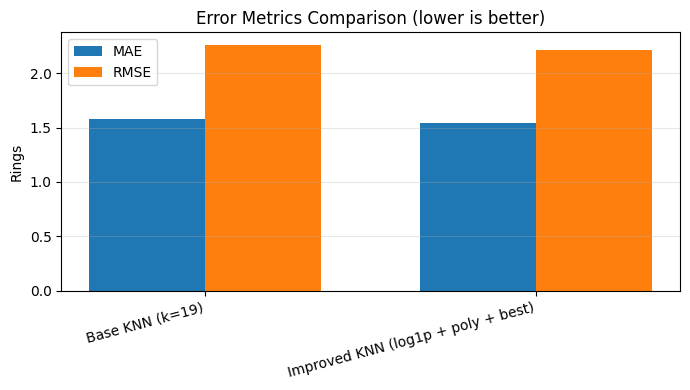

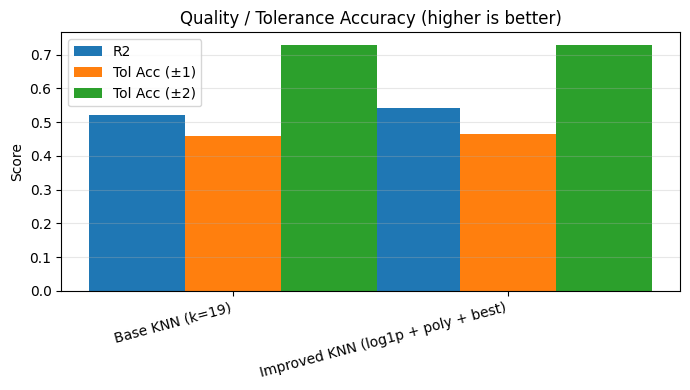

In [ ]:
# Comparison charts

# Error metrics (lower is better)
plt.figure(figsize=(7,4))
x = np.arange(len(comparison))
width = 0.35
plt.bar(x - width/2, comparison["MAE"], width, label="MAE")
plt.bar(x + width/2, comparison["RMSE"], width, label="RMSE")
plt.xticks(x, comparison["Model"], rotation=15, ha="right")
plt.title("Error Metrics Comparison (lower is better)")
plt.ylabel("Rings")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Fit / tolerance metrics (higher is better)
plt.figure(figsize=(7,4))
plt.bar(x - width, comparison["R2"], width, label="R2")
plt.bar(x, comparison["Tolerance Acc (±1)"], width, label="Tol Acc (±1)")
plt.bar(x + width, comparison["Tolerance Acc (±2)"], width, label="Tol Acc (±2)")
plt.xticks(x, comparison["Model"], rotation=15, ha="right")
plt.title("Quality / Tolerance Accuracy (higher is better)")
plt.ylabel("Score")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Define young/old threshold from training data
thr = 7
y_train_bin = (y_train >= thr).astype(int)
y_test_bin  = (y_test  >= thr).astype(int)

print(f"Young/Old threshold (median rings): {thr:.2f}")
print("Class balance in train (0=young, 1=old):")
print(pd.Series(y_train_bin).value_counts(normalize=True).rename("proportion"))

Young/Old threshold (median rings): 7.00
Class balance in train (0=young, 1=old):
Rings
1    0.892846
0    0.107154
Name: proportion, dtype: float64


In [ ]:
# Binary accuracy from the REGRESSION models (by thresholding their continuous predictions)
base_pred_bin = (pred_base >= thr).astype(int)
improved_pred_bin = (pred_improved >= thr).astype(int)

base_bin_acc = accuracy_score(y_test_bin, base_pred_bin)
improved_bin_acc = accuracy_score(y_test_bin, improved_pred_bin)

pd.DataFrame([
    {"Model": base_report.iloc[0]["Model"], "Binary Acc (Young/Old)": base_bin_acc},
    {"Model": improved_report.iloc[0]["Model"], "Binary Acc (Young/Old)": improved_bin_acc},
]).round(4)

,Model,Binary Acc (Young/Old)
0,Base KNN (k=19),0.9318
1,Improved KNN (log1p + poly + best),0.9402


In [ ]:
# Train a dedicated KNN CLASSIFIER using the SAME improved feature pipeline (log1p + poly)
clf_pipe = Pipeline([
    ("prep", preprocessor_improved),   # log1p + poly (numeric) + one-hot (Sex)
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

clf_param_grid = {
    "prep__num__poly__degree": [1, 2, 3],
    "knn__n_neighbors": list(range(1, 31, 2)),
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}

clf_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

clf_gs = GridSearchCV(
    clf_pipe,
    param_grid=clf_param_grid,
    scoring="accuracy",
    cv=clf_cv,
    n_jobs=-1
)

clf_gs.fit(X_train, y_train_bin)

print("Best classifier params:", clf_gs.best_params_)
print("Best CV accuracy:", round(clf_gs.best_score_, 4))

Best classifier params: {'knn__n_neighbors': 27, 'knn__p': 1, 'knn__weights': 'distance', 'prep__num__poly__degree': 3}
Best CV accuracy: 0.9342


In [ ]:
# Evaluate classifier on test set
clf_pred = clf_gs.predict(X_test)

acc = accuracy_score(y_test_bin, clf_pred)
f1 = f1_score(y_test_bin, clf_pred)
prec = precision_score(y_test_bin, clf_pred)
rec = recall_score(y_test_bin, clf_pred)

clf_report = pd.DataFrame([{
    "Model": "KNN Classifier (log1p + poly )",
    "Threshold (rings)": round(thr, 2),
    "Accuracy": acc,
    "F1": f1,
    "Precision": prec,
    "Recall": rec
}]).round(4)

clf_report

,Model,Threshold (rings),Accuracy,F1,Precision,Recall
0,KNN Classifier (log1p + poly ),7,0.9354,0.9643,0.9505,0.9786


In [ ]:
# Nice display for classifier results
def display_classifier_table(df, title="Classifier Results"):
    styled = (
        df.style
        .format({
            "Accuracy": "{:.2%}",
            "F1": "{:.4f}",
            "Precision": "{:.4f}",
            "Recall": "{:.4f}",
            "Threshold (rings)": "{:.2f}",
        })
        .set_caption(title)
        .hide(axis="index")
        .set_table_styles([
            {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold")]},
            {"selector": "th", "props": [("text-align", "left")]},
            {"selector": "td", "props": [("padding", "8px 12px")]},
        ])
        .background_gradient(subset=["Accuracy"], cmap="Blues")
    )
    display(styled)

display_classifier_table(clf_report, title="Young vs Old: KNN Classifier Results")

Model,Threshold (rings),Accuracy,F1,Precision,Recall
KNN Classifier (log1p + poly ),11.00,76.79%,0.6312,0.7004,0.5744


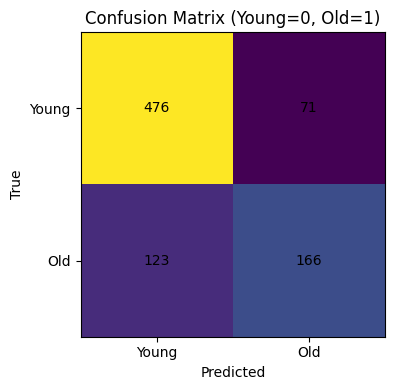

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_bin, clf_pred, labels=[0,1])

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix (Young=0, Old=1)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["Young", "Old"])
plt.yticks([0,1], ["Young", "Old"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.tight_layout()
plt.show()

In [ ]:
# Combined summary (regression metrics + young/old accuracy)
summary = comparison.copy()

# Add binary accuracy column for regression models
summary["Binary Acc (Young/Old)"] = [base_bin_acc, improved_bin_acc]

# Add classifier row (regression metrics not applicable)
summary = pd.concat([
    summary,
    pd.DataFrame([{
        "Model": clf_report.loc[0, "Model"],
        "MAE": np.nan,
        "RMSE": np.nan,
        "R2": np.nan,
        "Tolerance Acc (±1)": np.nan,
        "Tolerance Acc (±2)": np.nan,
        "Binary Acc (Young/Old)": acc
    }])
], ignore_index=True)

styled = (
    summary.style
    .format({
        "MAE": "{:.4f}",
        "RMSE": "{:.4f}",
        "R2": "{:.4f}",
        "Tolerance Acc (±1)": "{:.2%}",
        "Tolerance Acc (±2)": "{:.2%}",
        "Binary Acc (Young/Old)": "{:.2%}",
    }, na_rep="—")
    .set_caption("Overall Summary: Regression + Young/Old Classification")
    .hide(axis="index")
    .set_table_styles([
        {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold")]},
        {"selector": "th", "props": [("text-align", "left")]},
        {"selector": "td", "props": [("padding", "8px 12px")]},
    ])
)
display(styled)

Model,MAE,RMSE,R2,Tolerance Acc (±1),Tolerance Acc (±2),Binary Acc (Young/Old)
Base KNN (k=19),1.5798,2.2612,0.5220,45.93%,72.73%,75.72%
Improved KNN (log1p + poly + best),1.5380,2.2100,0.5434,46.41%,72.97%,76.08%
KNN Classifier (log1p + poly ),—,—,—,—,—,76.79%
